In [2]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import MySQLdb
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="", db="iot")
cursor = conn.cursor()
#cursor.execute('select time, source, destination, protocol, type, size from ip limit 250');
cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00" group by time')

rows = cursor.fetchall()

#cursor.execute('SELECT * FROM power LIMIT 5');
#rows2 = cursor.fetchall()

In [82]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
#df2 = pd.DataFrame( [[ij for ij in i] for i in rows2] )
#df.rename(columns={0: 'Time', 1: 'Source', 2: 'Destination', 3: 'Protocol', 4:'Type', 5:'Size'}, inplace=True);
df.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df['Size'] = pd.to_numeric(df['Size'])
df.info()
df.head()
#df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
Time    555 non-null datetime64[ns]
Size    555 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.8 KB


,Time,Size
0,2018-03-08 12:38:00,126.0
1,2018-03-08 12:38:01,1276.0
2,2018-03-08 12:38:02,1374.0
3,2018-03-08 12:38:03,690.0
4,2018-03-08 12:38:05,460.0


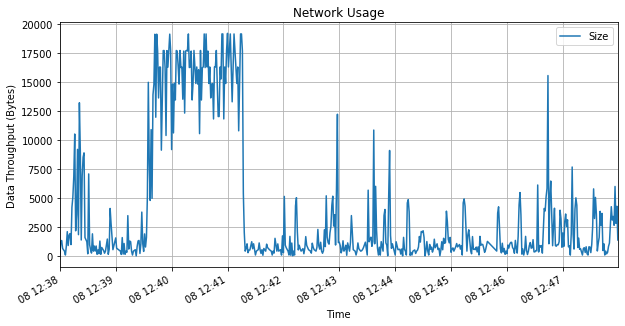

In [83]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()